## 1. Setup and Data Loading

In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
pd.set_option('display.max_rows', 100)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


In [17]:
# Load data
df = pd.read_csv('../artifacts/data/inventory_store_dept.csv')

# Convert date to datetime
df['ctx_date_month'] = pd.to_datetime(df['ctx_date_month'])

# Sort by store, item, and date
df = df.sort_values(['ctx_store_id', 'ctx_item_id', 'ctx_date_month'])

print(f"Dataset shape: {df.shape}")
print(f"\nDate range: {df['ctx_date_month'].min()} to {df['ctx_date_month'].max()}")
print(f"Number of unique stores: {df['ctx_store_id'].nunique()}")
print(f"Number of unique items: {df['ctx_item_id'].nunique()}")
print(f"Number of store-item combinations: {df.groupby(['ctx_store_id', 'ctx_item_id']).ngroups}")
print(f"\nSample data:")
print(df['ctx_date_month'].min())
print(df['ctx_date_month'].max())
df.head(10)



Dataset shape: (10699, 6)

Date range: 2015-04-01 00:00:00 to 2016-04-01 00:00:00
Number of unique stores: 1
Number of unique items: 823
Number of store-item combinations: 823

Sample data:
2015-04-01 00:00:00
2016-04-01 00:00:00


,predicted_label,tgt_monthly_sales,ctx_date_month,ctx_item_id,ctx_store_id,ctx_dept_id
2018,3.59,4,2015-04-01,FOODS_3_001,CA_1,FOODS_3
2239,6.23,7,2015-05-01,FOODS_3_001,CA_1,FOODS_3
1426,0.07,0,2015-06-01,FOODS_3_001,CA_1,FOODS_3
1085,0.07,0,2015-07-01,FOODS_3_001,CA_1,FOODS_3
972,0.07,0,2015-08-01,FOODS_3_001,CA_1,FOODS_3
4485,21.25,24,2015-09-01,FOODS_3_001,CA_1,FOODS_3
4389,20.30,23,2015-10-01,FOODS_3_001,CA_1,FOODS_3
4927,23.71,27,2015-11-01,FOODS_3_001,CA_1,FOODS_3
3954,17.66,20,2015-12-01,FOODS_3_001,CA_1,FOODS_3
3530,15.00,17,2016-01-01,FOODS_3_001,CA_1,FOODS_3


## 2. Configuration Parameters

Define all business rules and cost parameters for inventory optimization.

In [18]:
# Business Parameters
SERVICE_LEVEL = 0.95            # Target service level (95%)
Z_SCORE = stats.norm.ppf(SERVICE_LEVEL)  # ~1.645

# Time Parameters
LEAD_TIME_DAYS = 90             # 3 months lead time
DAYS_PER_MONTH = 30             # Average days per month
MONTHS_PER_YEAR = 12

# Cost Parameters
ORDER_COST = 100                # $ per order placed
UNIT_COST = 10                  # $ per unit
HOLDING_COST_RATE = 0.20        # 20% of unit cost annually
HOLDING_COST = UNIT_COST * HOLDING_COST_RATE  # $2 per unit per year
STOCKOUT_COST = 5               # $ lost revenue per unit not available

# Forecasting Parameters
ROLLING_WINDOW = 3              # Use 3-month rolling average for predictions
MIN_HISTORY = 2                 # Minimum months needed to make forecast

print("Configuration Parameters:")
print("=" * 50)
print(f"Service Level: {SERVICE_LEVEL * 100}%")
print(f"Z-Score: {Z_SCORE:.3f}")
print(f"Lead Time: {LEAD_TIME_DAYS} days")
print(f"\nCost Structure:")
print(f"  - Order Cost: ${ORDER_COST}")
print(f"  - Unit Cost: ${UNIT_COST}")
print(f"  - Annual Holding Cost: ${HOLDING_COST}/unit")
print(f"  - Stockout Cost: ${STOCKOUT_COST}/unit")
print(f"\nForecasting:")
print(f"  - Rolling Window: {ROLLING_WINDOW} months")
print(f"  - Minimum History: {MIN_HISTORY} months")

Configuration Parameters:
Service Level: 95.0%
Z-Score: 1.645
Lead Time: 90 days

Cost Structure:
  - Order Cost: $100
  - Unit Cost: $10
  - Annual Holding Cost: $2.0/unit
  - Stockout Cost: $5/unit

Forecasting:
  - Rolling Window: 3 months
  - Minimum History: 2 months


## 3. Inventory Simulation Functions

Core functions to simulate inventory decisions month-by-month.

In [19]:
def calculate_rolling_forecast(group):
    """
    Calculate rolling average forecast for each time period.
    Uses only past data (no look-ahead bias).
    """
    # Rolling mean of actual sales
    group['forecast'] = group["predicted_label"]
    #group['tgt_monthly_sales'].shift(1).rolling(
    #    window=ROLLING_WINDOW, min_periods=MIN_HISTORY
    #).mean()
    
    # Rolling std for safety stock calculation
    group['forecast_std'] = group['tgt_monthly_sales'].shift(1).rolling(
        window=ROLLING_WINDOW, min_periods=MIN_HISTORY
    ).std()
    
    # Fill missing std with mean * 0.5 as conservative estimate
    group['forecast_std'] = group['forecast_std'].fillna(group['forecast'] * 0.5)
    
    return group


def calculate_inventory_policies(forecast, forecast_std):
    """
    Calculate inventory policy parameters based on forecast.
    
    Returns:
    - safety_stock: Buffer inventory
    - reorder_point: When to order
    - order_quantity (EOQ): How much to order
    """
    # Convert monthly forecast to daily
    daily_demand = forecast / DAYS_PER_MONTH
    
    # Safety Stock = Z * σ * sqrt(lead_time_in_months)
    lead_time_months = LEAD_TIME_DAYS / DAYS_PER_MONTH
    safety_stock = Z_SCORE * forecast_std * np.sqrt(lead_time_months)
    
    # Demand During Lead Time
    ddlt = daily_demand * LEAD_TIME_DAYS
    
    # Reorder Point = DDLT + Safety Stock
    reorder_point = ddlt + safety_stock
    
    # Economic Order Quantity
    annual_demand = forecast * MONTHS_PER_YEAR
    if annual_demand > 0:
        eoq = np.sqrt((2 * annual_demand * ORDER_COST) / HOLDING_COST)
    else:
        eoq = 0
    
    return safety_stock, reorder_point, eoq, daily_demand


def simulate_month(row, current_inventory, orders_in_transit):
    """
    Simulate one month of inventory operations.
    
    Returns:
    - ending_inventory: Inventory at end of month
    - order_placed: Units ordered this month
    - stockout_units: Units we couldn't fulfill
    - holding_cost: Monthly holding cost
    - order_cost: Monthly ordering cost
    - stockout_cost: Monthly stockout cost
    """
    # Receive orders from 3 months ago (lead time = 90 days)
    incoming_inventory = orders_in_transit.get('incoming', 0)
    current_inventory += incoming_inventory
    
    # Check if we need to order (inventory <= ROP)
    reorder_point = row['reorder_point']
    order_quantity = row['order_quantity']
    
    if current_inventory <= reorder_point and order_quantity > 0:
        order_placed = order_quantity
        order_cost = ORDER_COST
    else:
        order_placed = 0
        order_cost = 0
    
    # Fulfill demand
    actual_demand = row['tgt_monthly_sales']
    units_sold = min(current_inventory, actual_demand)
    stockout_units = max(0, actual_demand - current_inventory)
    
    # Update inventory
    ending_inventory = max(0, current_inventory - actual_demand)
    
    # Calculate costs (monthly holding cost)
    avg_inventory = (current_inventory + ending_inventory) / 2
    holding_cost = avg_inventory * (HOLDING_COST / MONTHS_PER_YEAR)
    stockout_cost = stockout_units * STOCKOUT_COST
    
    return {
        'beginning_inventory': current_inventory - incoming_inventory,
        'incoming_inventory': incoming_inventory,
        'ending_inventory': ending_inventory,
        'order_placed': order_placed,
        'units_sold': units_sold,
        'stockout_units': stockout_units,
        'holding_cost': holding_cost,
        'order_cost': order_cost,
        'stockout_cost': stockout_cost
    }

print("✓ Simulation functions defined")

✓ Simulation functions defined


## 4. Run Inventory Simulation

Simulate inventory decisions for all store-item combinations across all time periods.

In [20]:
# Calculate forecasts using rolling averages
print("Calculating rolling average forecasts...")
df = df.groupby(['ctx_store_id', 'ctx_item_id']).apply(calculate_rolling_forecast).reset_index(drop=True)

# Calculate inventory policies based on forecasts
print("Calculating inventory policies (Safety Stock, ROP, EOQ)...")
df[['safety_stock', 'reorder_point', 'order_quantity', 'daily_demand']] = df.apply(
    lambda row: pd.Series(calculate_inventory_policies(row['forecast'], row['forecast_std'])) 
    if pd.notna(row['forecast']) else pd.Series([np.nan, np.nan, np.nan, np.nan]),
    axis=1
)

print("\n✓ Forecasts and policies calculated")
print(f"Total forecasts generated: {df['forecast'].notna().sum():,}")
print(f"\nSample with forecast and policies:")
df[['ctx_store_id', 'ctx_item_id', 'ctx_date_month', 'tgt_monthly_sales', 
    'forecast', 'safety_stock', 'reorder_point', 'order_quantity']].head(20)

Calculating rolling average forecasts...
Calculating inventory policies (Safety Stock, ROP, EOQ)...

✓ Forecasts and policies calculated
Total forecasts generated: 10,699

Sample with forecast and policies:


,ctx_store_id,ctx_item_id,ctx_date_month,tgt_monthly_sales,forecast,safety_stock,reorder_point,order_quantity
0,CA_1,FOODS_3_001,2015-04-01,4,3.59,5.11,15.87,65.60
1,CA_1,FOODS_3_001,2015-05-01,7,6.23,8.87,27.56,86.45
2,CA_1,FOODS_3_001,2015-06-01,0,0.07,6.04,6.24,8.88
3,CA_1,FOODS_3_001,2015-07-01,0,0.07,10.01,10.20,8.88
4,CA_1,FOODS_3_001,2015-08-01,0,0.07,11.51,11.71,8.88
5,CA_1,FOODS_3_001,2015-09-01,24,21.25,0.00,63.74,159.67
6,CA_1,FOODS_3_001,2015-10-01,23,20.30,39.48,100.38,156.08
7,CA_1,FOODS_3_001,2015-11-01,27,23.71,38.68,109.82,168.69
8,CA_1,FOODS_3_001,2015-12-01,20,17.66,5.93,58.92,145.58
9,CA_1,FOODS_3_001,2016-01-01,17,15.00,10.01,55.01,134.17


In [21]:
# Run month-by-month simulation
print("Running month-by-month inventory simulation...")
print("This simulates actual inventory decisions based on the calculated policies.\n")

results = []
inventory_tracker = {}  # Track current inventory per store-item
order_tracker = {}      # Track orders in transit (lead time = 3 months)

# Process each month in chronological order
for idx, row in df.iterrows():
    store_item = (row['ctx_store_id'], row['ctx_item_id'])
    
    # Skip if no forecast available yet
    if pd.isna(row['forecast']):
        continue
    
    # Initialize inventory if new store-item
    if store_item not in inventory_tracker:
        # Start with safety stock + one order quantity
        initial_inv = row['safety_stock'] + row['order_quantity']
        inventory_tracker[store_item] = initial_inv
        order_tracker[store_item] = []  # Queue of orders in transit
    
    # Get orders arriving this month (placed 3 months ago)
    orders = order_tracker[store_item]
    incoming = orders.pop(0) if len(orders) > 0 else 0
    
    # Simulate this month
    current_inv = inventory_tracker[store_item]
    month_result = simulate_month(row, current_inv, {'incoming': incoming})
    
    # Update inventory tracker
    inventory_tracker[store_item] = month_result['ending_inventory']
    
    # If order placed, add to transit queue (arrives in 3 months)
    if month_result['order_placed'] > 0:
        # Pad queue to 3 months if needed
        while len(order_tracker[store_item]) < 3:
            order_tracker[store_item].append(0)
        order_tracker[store_item].append(month_result['order_placed'])
    
    # Store results
    result_row = {
        'ctx_store_id': row['ctx_store_id'],
        'ctx_item_id': row['ctx_item_id'],
        'ctx_date_month': row['ctx_date_month'],
        'actual_demand': row['tgt_monthly_sales'],
        'forecast': row['forecast'],
        'forecast_error': row['tgt_monthly_sales'] - row['forecast'],
        'forecast_error_pct': abs(row['tgt_monthly_sales'] - row['forecast']) / row['tgt_monthly_sales'] * 100 if row['tgt_monthly_sales'] > 0 else 0,
        'safety_stock': row['safety_stock'],
        'reorder_point': row['reorder_point'],
        'order_quantity': row['order_quantity'],
        **month_result
    }
    results.append(result_row)

# Convert to DataFrame
sim_df = pd.DataFrame(results)

print(f"✓ Simulation complete!")
print(f"Total months simulated: {len(sim_df):,}")
print(f"Total orders placed: {(sim_df['order_placed'] > 0).sum():,}")
print(f"Total stockouts: {(sim_df['stockout_units'] > 0).sum():,}")
print(f"\nSample simulation results:")
sim_df.head(20)

Running month-by-month inventory simulation...
This simulates actual inventory decisions based on the calculated policies.

✓ Simulation complete!
Total months simulated: 10,699
Total orders placed: 3,330
Total stockouts: 1,254

Sample simulation results:


,ctx_store_id,ctx_item_id,ctx_date_month,actual_demand,forecast,forecast_error,forecast_error_pct,safety_stock,reorder_point,order_quantity,beginning_inventory,incoming_inventory,ending_inventory,order_placed,units_sold,stockout_units,holding_cost,order_cost,stockout_cost
0,CA_1,FOODS_3_001,2015-04-01,4,3.59,0.41,10.35,5.11,15.87,65.60,70.71,0.00,66.71,0.00,4.00,0.00,11.45,0,0.00
1,CA_1,FOODS_3_001,2015-05-01,7,6.23,0.77,11.02,8.87,27.56,86.45,66.71,0.00,59.71,0.00,7.00,0.00,10.53,0,0.00
2,CA_1,FOODS_3_001,2015-06-01,0,0.07,-0.07,0.00,6.04,6.24,8.88,59.71,0.00,59.71,0.00,0.00,0.00,9.95,0,0.00
3,CA_1,FOODS_3_001,2015-07-01,0,0.07,-0.07,0.00,10.01,10.20,8.88,59.71,0.00,59.71,0.00,0.00,0.00,9.95,0,0.00
4,CA_1,FOODS_3_001,2015-08-01,0,0.07,-0.07,0.00,11.51,11.71,8.88,59.71,0.00,59.71,0.00,0.00,0.00,9.95,0,0.00
5,CA_1,FOODS_3_001,2015-09-01,24,21.25,2.75,11.47,0.00,63.74,159.67,59.71,0.00,35.71,159.67,24.00,0.00,7.95,100,0.00
6,CA_1,FOODS_3_001,2015-10-01,23,20.30,2.70,11.73,39.48,100.38,156.08,35.71,0.00,12.71,156.08,23.00,0.00,4.03,100,0.00
7,CA_1,FOODS_3_001,2015-11-01,27,23.71,3.29,12.17,38.68,109.82,168.69,12.71,0.00,0.00,168.69,12.71,14.29,1.06,100,71.46
8,CA_1,FOODS_3_001,2015-12-01,20,17.66,2.34,11.69,5.93,58.92,145.58,0.00,0.00,0.00,145.58,0.00,20.00,0.00,100,100.00
9,CA_1,FOODS_3_001,2016-01-01,17,15.00,2.00,11.76,10.01,55.01,134.17,0.00,159.67,142.67,0.00,17.00,0.00,25.20,0,0.00


## 5. Calculate Comprehensive KPIs

Calculate all relevant inventory optimization metrics.

In [22]:
# Aggregate KPIs by store-item
print("Calculating comprehensive KPIs...\n")

kpis = sim_df.groupby(['ctx_store_id', 'ctx_item_id']).agg({
    # Demand Metrics
    'actual_demand': ['sum', 'mean', 'std'],
    'forecast': 'mean',
    'forecast_error_pct': 'mean',
    
    # Inventory Levels
    'ending_inventory': 'mean',
    'safety_stock': 'mean',
    
    # Orders
    'order_placed': lambda x: (x > 0).sum(),  # Number of orders
    
    # Service Level
    'units_sold': 'sum',
    'stockout_units': 'sum',
    
    # Costs
    'holding_cost': 'sum',
    'order_cost': 'sum',
    'stockout_cost': 'sum'
}).reset_index()

# Flatten column names
kpis.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in kpis.columns.values]
kpis.columns = ['ctx_store_id', 'ctx_item_id', 'total_demand', 'avg_monthly_demand', 
                'demand_std', 'avg_forecast', 'avg_mape', 'avg_inventory', 
                'avg_safety_stock', 'num_orders', 'units_sold', 'stockout_units',
                'total_holding_cost', 'total_order_cost', 'total_stockout_cost']

# Calculate derived KPIs
kpis['total_cost'] = kpis['total_holding_cost'] + kpis['total_order_cost'] + kpis['total_stockout_cost']

# Service Level = Units Sold / Total Demand
kpis['service_level'] = (kpis['units_sold'] / (kpis['units_sold'] + kpis['stockout_units']) * 100)

# Fill Rate = % of demand met from stock
kpis['fill_rate'] = (kpis['units_sold'] / kpis['total_demand'] * 100)

# Inventory Turnover = Total Demand / Avg Inventory
kpis['inventory_turnover'] = kpis['total_demand'] / kpis['avg_inventory']

# Days on Hand = (Avg Inventory / Avg Monthly Demand) * 30
kpis['days_on_hand'] = (kpis['avg_inventory'] / kpis['avg_monthly_demand']) * DAYS_PER_MONTH

# Coefficient of Variation
kpis['cv'] = kpis['demand_std'] / kpis['avg_monthly_demand']

# Cost per unit sold
kpis['cost_per_unit'] = kpis['total_cost'] / kpis['units_sold']

print("✓ KPIs calculated!")
print(f"\nStore-Item KPIs:")
kpis.head(20)

Calculating comprehensive KPIs...

✓ KPIs calculated!

Store-Item KPIs:


,ctx_store_id,ctx_item_id,total_demand,avg_monthly_demand,demand_std,avg_forecast,avg_mape,avg_inventory,avg_safety_stock,num_orders,units_sold,stockout_units,total_holding_cost,total_order_cost,total_stockout_cost,total_cost,service_level,fill_rate,inventory_turnover,days_on_hand,cv,cost_per_unit
0,CA_1,FOODS_3_001,173,13.31,9.90,11.76,8.89,135.99,12.15,4,138.71,34.29,306.20,400,171.46,877.66,80.18,80.18,1.27,306.57,0.74,6.33
1,CA_1,FOODS_3_002,835,64.23,38.89,58.16,9.53,343.25,83.77,4,751.28,83.72,806.32,400,418.59,1624.91,89.97,89.97,2.43,160.32,0.61,2.16
2,CA_1,FOODS_3_003,243,18.69,17.90,16.57,7.22,280.51,25.12,4,224.94,18.06,626.51,400,90.30,1116.81,92.57,92.57,0.87,450.20,0.96,4.96
3,CA_1,FOODS_3_004,420,32.31,8.86,28.49,11.79,176.68,20.54,4,381.91,38.09,414.64,400,190.44,1005.08,90.93,90.93,2.38,164.06,0.27,2.63
4,CA_1,FOODS_3_005,220,16.92,6.37,14.94,11.63,220.19,18.39,4,218.74,1.26,495.31,400,6.32,901.63,99.43,99.43,1.00,390.34,0.38,4.12
5,CA_1,FOODS_3_006,197,15.15,6.04,13.38,11.51,146.75,6.56,4,162.71,34.29,331.53,400,171.46,902.99,82.59,82.59,1.34,290.53,0.40,5.55
6,CA_1,FOODS_3_007,1524,117.23,71.57,106.08,10.65,755.62,145.60,5,1057.50,466.50,1725.30,500,2332.51,4557.80,69.39,69.39,2.02,193.37,0.61,4.31
7,CA_1,FOODS_3_008,1224,94.15,103.99,81.57,8.57,887.78,183.21,5,351.98,872.02,1952.86,500,4360.11,6812.97,28.76,28.76,1.38,282.87,1.10,19.36
8,CA_1,FOODS_3_009,273,21.00,7.47,18.50,11.84,76.16,17.35,4,231.93,41.07,184.34,400,205.37,789.71,84.95,84.95,3.58,108.80,0.36,3.41
9,CA_1,FOODS_3_010,253,19.46,6.49,17.12,11.91,128.20,20.15,4,241.02,11.98,297.85,400,59.89,757.74,95.27,95.27,1.97,197.62,0.33,3.14


## 6. Summary KPI Table

Comprehensive table with all key performance indicators.

In [23]:
# Create comprehensive KPI summary table
print("="*100)
print("INVENTORY OPTIMIZATION KPI SUMMARY")
print("="*100)

summary_kpis = pd.DataFrame([
    {
        'Category': 'Demand Forecasting',
        'Metric': 'Average MAPE',
        'Value': f"{kpis['avg_mape'].mean():.2f}%",
        'Interpretation': 'Lower is better - forecast accuracy'
    },
    {
        'Category': 'Demand Forecasting',
        'Metric': 'Forecast Bias',
        'Value': f"{sim_df['forecast_error'].mean():.2f} units",
        'Interpretation': 'Close to 0 is best - systematic over/under forecasting'
    },
    {
        'Category': 'Service Level',
        'Metric': 'Overall Service Level',
        'Value': f"{kpis['service_level'].mean():.2f}%",
        'Interpretation': f"Target: {SERVICE_LEVEL*100}% - % of demand met"
    },
    {
        'Category': 'Service Level',
        'Metric': 'Fill Rate',
        'Value': f"{kpis['fill_rate'].mean():.2f}%",
        'Interpretation': 'Same as service level in this context'
    },
    {
        'Category': 'Service Level',
        'Metric': 'Total Stockouts',
        'Value': f"{kpis['stockout_units'].sum():,.0f} units",
        'Interpretation': 'Total units we could not fulfill'
    },
    {
        'Category': 'Inventory Efficiency',
        'Metric': 'Avg Days on Hand',
        'Value': f"{kpis['days_on_hand'].mean():.1f} days",
        'Interpretation': 'Target: 30-45 days for food retail'
    },
    {
        'Category': 'Inventory Efficiency',
        'Metric': 'Inventory Turnover',
        'Value': f"{kpis['inventory_turnover'].mean():.2f}x",
        'Interpretation': 'Target: 8-12x/year for good performance'
    },
    {
        'Category': 'Inventory Efficiency',
        'Metric': 'Avg Inventory Level',
        'Value': f"{kpis['avg_inventory'].mean():,.1f} units",
        'Interpretation': 'Average units held in stock'
    },
    {
        'Category': 'Inventory Efficiency',
        'Metric': 'Avg Safety Stock',
        'Value': f"{kpis['avg_safety_stock'].mean():,.1f} units",
        'Interpretation': 'Buffer inventory for uncertainty'
    },
    {
        'Category': 'Operational',
        'Metric': 'Total Orders Placed',
        'Value': f"{kpis['num_orders'].sum():,.0f}",
        'Interpretation': 'Number of replenishment orders'
    },
    {
        'Category': 'Operational',
        'Metric': 'Avg Orders per SKU',
        'Value': f"{kpis['num_orders'].mean():.1f}",
        'Interpretation': 'Order frequency per store-item'
    },
    {
        'Category': 'Financial',
        'Metric': 'Total Holding Cost',
        'Value': f"${kpis['total_holding_cost'].sum():,.0f}",
        'Interpretation': 'Cost of carrying inventory'
    },
    {
        'Category': 'Financial',
        'Metric': 'Total Order Cost',
        'Value': f"${kpis['total_order_cost'].sum():,.0f}",
        'Interpretation': 'Cost of placing orders'
    },
    {
        'Category': 'Financial',
        'Metric': 'Total Stockout Cost',
        'Value': f"${kpis['total_stockout_cost'].sum():,.0f}",
        'Interpretation': 'Lost revenue from stockouts'
    },
    {
        'Category': 'Financial',
        'Metric': 'Total Inventory Cost',
        'Value': f"${kpis['total_cost'].sum():,.0f}",
        'Interpretation': 'Sum of all inventory-related costs'
    },
    {
        'Category': 'Financial',
        'Metric': 'Cost per Unit Sold',
        'Value': f"${kpis['cost_per_unit'].mean():.2f}",
        'Interpretation': 'Average inventory cost per unit'
    },
    {
        'Category': 'Demand',
        'Metric': 'Total Demand',
        'Value': f"{kpis['total_demand'].sum():,.0f} units",
        'Interpretation': 'Total units demanded across all periods'
    },
    {
        'Category': 'Demand',
        'Metric': 'Avg Monthly Demand',
        'Value': f"{kpis['avg_monthly_demand'].mean():.1f} units",
        'Interpretation': 'Average units per month per SKU'
    },
    {
        'Category': 'Demand',
        'Metric': 'Demand Variability (CV)',
        'Value': f"{kpis['cv'].mean():.2f}",
        'Interpretation': 'Lower is better - demand predictability'
    }
])

# Display the table
print("\n")
print(summary_kpis.to_string(index=False))
print("\n" + "="*100)

INVENTORY OPTIMIZATION KPI SUMMARY


            Category                  Metric         Value                                         Interpretation
  Demand Forecasting            Average MAPE        10.85%                    Lower is better - forecast accuracy
  Demand Forecasting           Forecast Bias    7.63 units Close to 0 is best - systematic over/under forecasting
       Service Level   Overall Service Level        86.92%                        Target: 95.0% - % of demand met
       Service Level               Fill Rate        86.92%                  Same as service level in this context
       Service Level         Total Stockouts 121,207 units                       Total units we could not fulfill
Inventory Efficiency        Avg Days on Hand      inf days                     Target: 30-45 days for food retail
Inventory Efficiency      Inventory Turnover         3.67x                Target: 8-12x/year for good performance
Inventory Efficiency     Avg Inventory Level   331.

## 7. KPI Breakdown by Store

In [24]:
# Aggregate KPIs by store
store_kpis = kpis.groupby('ctx_store_id').agg({
    'total_demand': 'sum',
    'avg_mape': 'mean',
    'service_level': 'mean',
    'days_on_hand': 'mean',
    'inventory_turnover': 'mean',
    'num_orders': 'sum',
    'total_cost': 'sum',
    'stockout_units': 'sum'
}).reset_index()

store_kpis = store_kpis.sort_values('total_demand', ascending=False)

print("="*100)
print("KPI SUMMARY BY STORE")
print("="*100)
print(store_kpis.to_string(index=False))
print("\n" + "="*100)

KPI SUMMARY BY STORE
ctx_store_id  total_demand  avg_mape  service_level  days_on_hand  inventory_turnover  num_orders  total_cost  stockout_units
        CA_1        806230     10.85          86.92           inf                3.67        3330    1.59e+06       121206.83



## 8. Performance Assessment

Evaluate how well the inventory system performed against benchmarks.

In [25]:
# Performance assessment
avg_doh = kpis['days_on_hand'].mean()
avg_turnover = kpis['inventory_turnover'].mean()
avg_service = kpis['service_level'].mean()
avg_mape = kpis['avg_mape'].mean()

print("="*100)
print("PERFORMANCE ASSESSMENT vs. BENCHMARKS")
print("="*100)

def assess_metric(value, thresholds, higher_better=False):
    """Assess if metric meets benchmarks"""
    if higher_better:
        if value >= thresholds['excellent']:
            return '✅ EXCELLENT'
        elif value >= thresholds['good']:
            return '👍 GOOD'
        elif value >= thresholds['average']:
            return '⚠️ AVERAGE'
        else:
            return '❌ NEEDS IMPROVEMENT'
    else:
        if value <= thresholds['excellent']:
            return '✅ EXCELLENT'
        elif value <= thresholds['good']:
            return '👍 GOOD'
        elif value <= thresholds['average']:
            return '⚠️ AVERAGE'
        else:
            return '❌ NEEDS IMPROVEMENT'

print(f"\n1. Days on Hand: {avg_doh:.1f} days")
print(f"   Rating: {assess_metric(avg_doh, {'excellent': 30, 'good': 45, 'average': 60})}")
print(f"   Target: < 45 days (food retail)")

print(f"\n2. Inventory Turnover: {avg_turnover:.2f}x per period")
print(f"   Rating: {assess_metric(avg_turnover, {'excellent': 12, 'good': 8, 'average': 4}, higher_better=True)}")
print(f"   Target: > 8x per year")

print(f"\n3. Service Level: {avg_service:.2f}%")
print(f"   Rating: {assess_metric(avg_service, {'excellent': 98, 'good': 95, 'average': 90}, higher_better=True)}")
print(f"   Target: {SERVICE_LEVEL*100}%")

print(f"\n4. Forecast Accuracy (MAPE): {avg_mape:.2f}%")
print(f"   Rating: {assess_metric(avg_mape, {'excellent': 15, 'good': 20, 'average': 30})}")
print(f"   Target: < 20% (rolling average baseline)")

print(f"\n5. Total Inventory Cost: ${kpis['total_cost'].sum():,.0f}")
print(f"   Components:")
print(f"     - Holding: ${kpis['total_holding_cost'].sum():,.0f} ({kpis['total_holding_cost'].sum()/kpis['total_cost'].sum()*100:.1f}%)")
print(f"     - Ordering: ${kpis['total_order_cost'].sum():,.0f} ({kpis['total_order_cost'].sum()/kpis['total_cost'].sum()*100:.1f}%)")
print(f"     - Stockouts: ${kpis['total_stockout_cost'].sum():,.0f} ({kpis['total_stockout_cost'].sum()/kpis['total_cost'].sum()*100:.1f}%)")

print("\n" + "="*100)

PERFORMANCE ASSESSMENT vs. BENCHMARKS

1. Days on Hand: inf days
   Rating: ❌ NEEDS IMPROVEMENT
   Target: < 45 days (food retail)

2. Inventory Turnover: 3.67x per period
   Rating: ❌ NEEDS IMPROVEMENT
   Target: > 8x per year

3. Service Level: 86.92%
   Rating: ❌ NEEDS IMPROVEMENT
   Target: 95.0%

4. Forecast Accuracy (MAPE): 10.85%
   Rating: ✅ EXCELLENT
   Target: < 20% (rolling average baseline)

5. Total Inventory Cost: $1,586,918
   Components:
     - Holding: $647,884 (40.8%)
     - Ordering: $333,000 (21.0%)
     - Stockouts: $606,034 (38.2%)



## 9. Visualizations

ValueError: supplied range of [3.7537827474486583, inf] is not finite

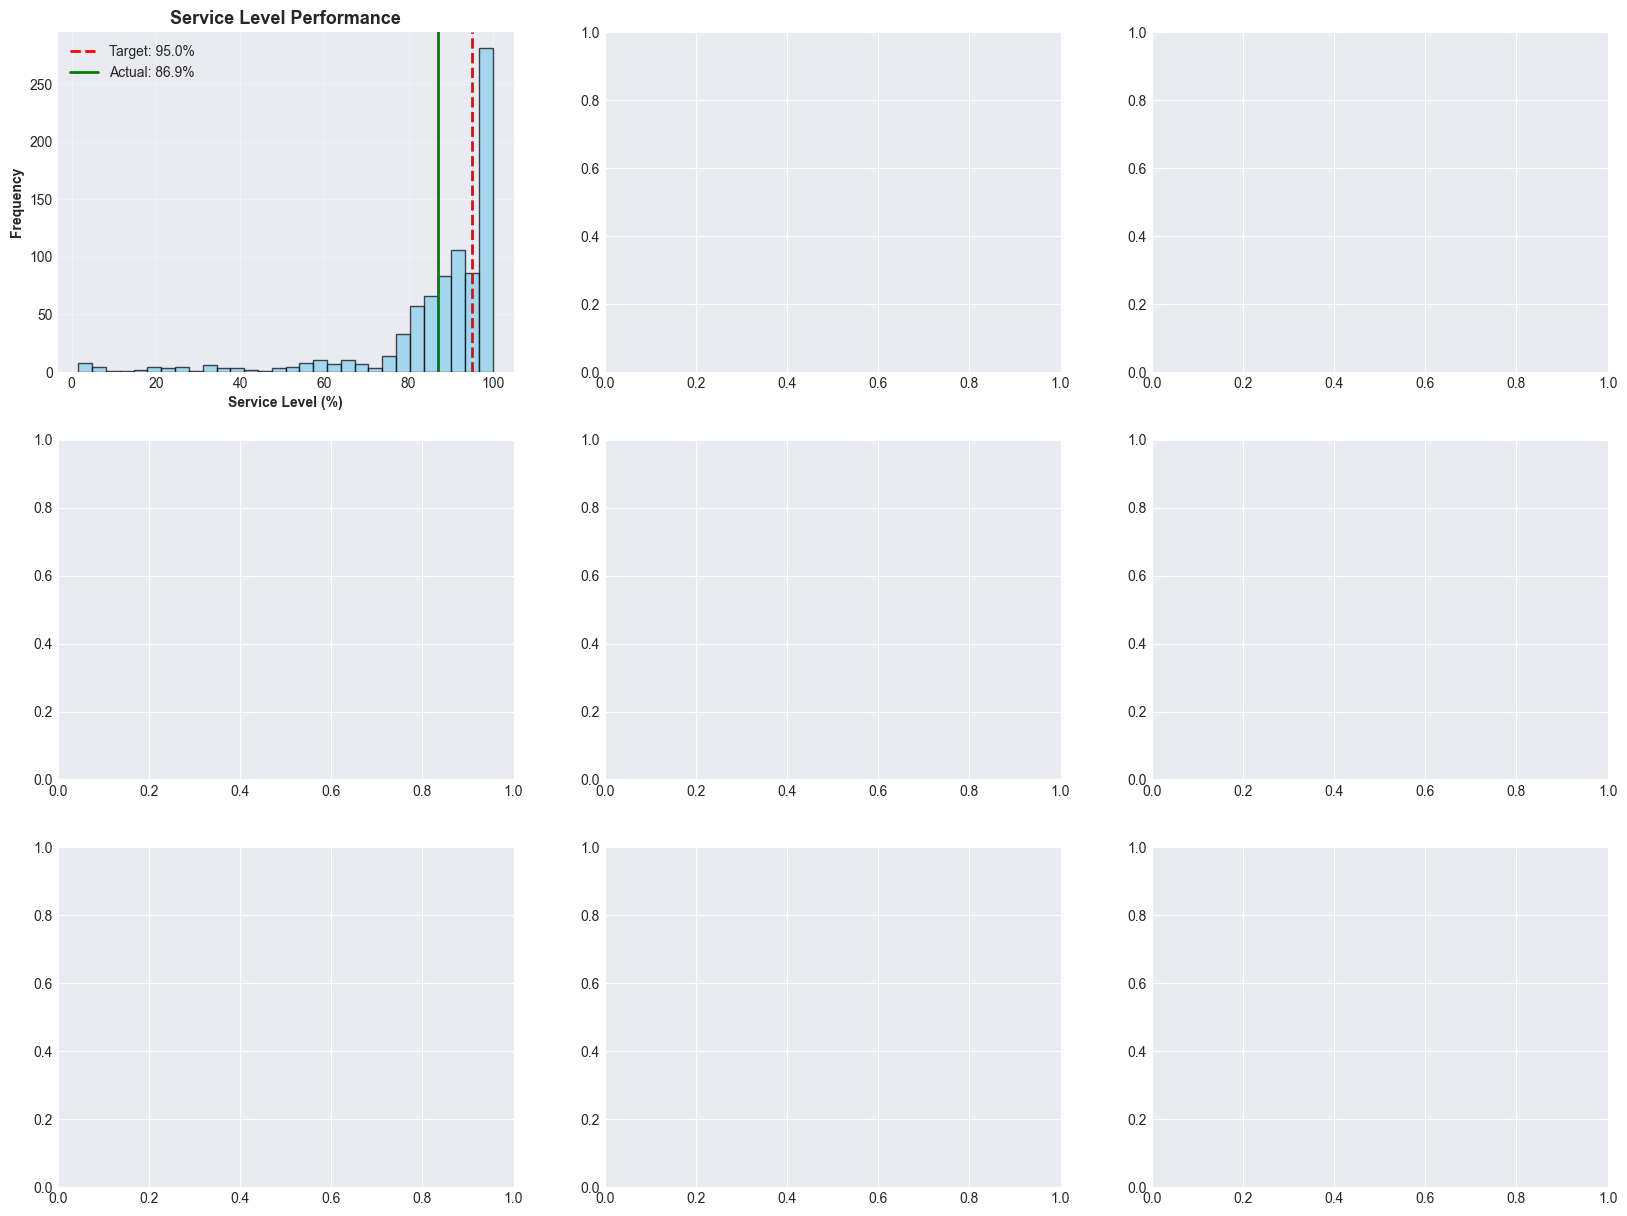

In [26]:
# Create comprehensive visualization dashboard
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Plot 1: Service Level Distribution
ax1 = axes[0, 0]
ax1.hist(kpis['service_level'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(SERVICE_LEVEL*100, color='red', linestyle='--', linewidth=2, label=f'Target: {SERVICE_LEVEL*100}%')
ax1.axvline(kpis['service_level'].mean(), color='green', linestyle='-', linewidth=2, label=f'Actual: {kpis["service_level"].mean():.1f}%')
ax1.set_xlabel('Service Level (%)', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Service Level Performance', fontweight='bold', fontsize=13)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Days on Hand Distribution
ax2 = axes[0, 1]
ax2.hist(kpis['days_on_hand'], bins=30, edgecolor='black', alpha=0.7, color='coral')
ax2.axvline(45, color='blue', linestyle='--', linewidth=2, label='Good Threshold: 45d')
ax2.axvline(kpis['days_on_hand'].mean(), color='darkred', linestyle='-', linewidth=2, label=f'Actual: {kpis["days_on_hand"].mean():.1f}d')
ax2.set_xlabel('Days on Hand', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Inventory Velocity', fontweight='bold', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Forecast Accuracy (MAPE) Distribution
ax3 = axes[0, 2]
ax3.hist(kpis['avg_mape'], bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
ax3.axvline(20, color='orange', linestyle='--', linewidth=2, label='Good: <20%')
ax3.axvline(kpis['avg_mape'].mean(), color='darkgreen', linestyle='-', linewidth=2, label=f'Actual: {kpis["avg_mape"].mean():.1f}%')
ax3.set_xlabel('MAPE (%)', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Forecast Accuracy', fontweight='bold', fontsize=13)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Cost Breakdown
ax4 = axes[1, 0]
cost_data = [
    kpis['total_holding_cost'].sum(),
    kpis['total_order_cost'].sum(),
    kpis['total_stockout_cost'].sum()
]
colors = ['#ff9999', '#66b3ff', '#99ff99']
ax4.pie(cost_data, labels=['Holding Cost', 'Order Cost', 'Stockout Cost'], 
        autopct='%1.1f%%', colors=colors, startangle=90)
ax4.set_title('Total Cost Breakdown', fontweight='bold', fontsize=13)

# Plot 5: Store Performance - Service Level
ax5 = axes[1, 1]
store_kpis_sorted = store_kpis.sort_values('service_level')
colors_sl = ['green' if x >= 95 else 'orange' if x >= 90 else 'red' for x in store_kpis_sorted['service_level']]
ax5.barh(store_kpis_sorted['ctx_store_id'], store_kpis_sorted['service_level'], color=colors_sl, edgecolor='black')
ax5.axvline(95, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Target: 95%')
ax5.set_xlabel('Service Level (%)', fontweight='bold')
ax5.set_ylabel('Store', fontweight='bold')
ax5.set_title('Service Level by Store', fontweight='bold', fontsize=13)
ax5.legend()
ax5.grid(True, alpha=0.3, axis='x')

# Plot 6: Store Performance - Days on Hand
ax6 = axes[1, 2]
store_kpis_sorted2 = store_kpis.sort_values('days_on_hand')
colors_doh = ['green' if x < 45 else 'orange' if x < 60 else 'red' for x in store_kpis_sorted2['days_on_hand']]
ax6.barh(store_kpis_sorted2['ctx_store_id'], store_kpis_sorted2['days_on_hand'], color=colors_doh, edgecolor='black')
ax6.axvline(45, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='Good: <45d')
ax6.set_xlabel('Days on Hand', fontweight='bold')
ax6.set_ylabel('Store', fontweight='bold')
ax6.set_title('Days on Hand by Store', fontweight='bold', fontsize=13)
ax6.legend()
ax6.grid(True, alpha=0.3, axis='x')

# Plot 7: Inventory Turnover Distribution
ax7 = axes[2, 0]
ax7.hist(kpis['inventory_turnover'], bins=30, edgecolor='black', alpha=0.7, color='gold')
ax7.axvline(8, color='green', linestyle='--', linewidth=2, label='Good: >8x')
ax7.axvline(kpis['inventory_turnover'].mean(), color='darkred', linestyle='-', linewidth=2, 
            label=f'Actual: {kpis["inventory_turnover"].mean():.1f}x')
ax7.set_xlabel('Inventory Turnover (x)', fontweight='bold')
ax7.set_ylabel('Frequency', fontweight='bold')
ax7.set_title('Inventory Turnover Rate', fontweight='bold', fontsize=13)
ax7.legend()
ax7.grid(True, alpha=0.3)

# Plot 8: Stockouts Over Time
ax8 = axes[2, 1]
stockouts_time = sim_df.groupby('ctx_date_month')['stockout_units'].sum()
ax8.plot(stockouts_time.index, stockouts_time.values, marker='o', linewidth=2, markersize=6, color='red')
ax8.set_xlabel('Date', fontweight='bold')
ax8.set_ylabel('Total Stockout Units', fontweight='bold')
ax8.set_title('Stockouts Over Time', fontweight='bold', fontsize=13)
ax8.grid(True, alpha=0.3)
plt.setp(ax8.xaxis.get_majorticklabels(), rotation=45)

# Plot 9: Cost per Unit Distribution
ax9 = axes[2, 2]
ax9.hist(kpis['cost_per_unit'], bins=30, edgecolor='black', alpha=0.7, color='purple')
ax9.axvline(kpis['cost_per_unit'].mean(), color='red', linestyle='-', linewidth=2, 
            label=f'Mean: ${kpis["cost_per_unit"].mean():.2f}')
ax9.set_xlabel('Cost per Unit ($)', fontweight='bold')
ax9.set_ylabel('Frequency', fontweight='bold')
ax9.set_title('Inventory Cost Efficiency', fontweight='bold', fontsize=13)
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.suptitle('Inventory Optimization Performance Dashboard', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 10. Export Results

In [ ]:
# Export comprehensive results
print("Exporting results...")

# Detailed simulation results
sim_df.to_csv('../artifacts/data/inventory_simulation_results.csv', index=False)
print("✓ Saved: inventory_simulation_results.csv")

# Store-item KPIs
kpis.to_csv('../artifacts/data/inventory_kpis_by_sku.csv', index=False)
print("✓ Saved: inventory_kpis_by_sku.csv")

# Store-level KPIs
store_kpis.to_csv('../artifacts/data/inventory_kpis_by_store.csv', index=False)
print("✓ Saved: inventory_kpis_by_store.csv")

# Summary KPI table
summary_kpis.to_csv('../artifacts/data/inventory_kpi_summary.csv', index=False)
print("✓ Saved: inventory_kpi_summary.csv")

print("\n✓ All results exported successfully!")

Exporting results...
✓ Saved: inventory_simulation_results.csv
✓ Saved: inventory_kpis_by_sku.csv
✓ Saved: inventory_kpis_by_store.csv
✓ Saved: inventory_kpi_summary.csv

✓ All results exported successfully!


## 11. Key Insights & Recommendations

In [27]:
print("="*100)
print("KEY INSIGHTS & RECOMMENDATIONS")
print("="*100)

print("\n🎯 SERVICE LEVEL PERFORMANCE:")
if avg_service >= 95:
    print(f"   ✅ Service level of {avg_service:.1f}% meets target")
else:
    print(f"   ❌ Service level of {avg_service:.1f}% is below {SERVICE_LEVEL*100}% target")
    print(f"   → Consider increasing safety stock or reducing lead times")

print("\n📦 INVENTORY EFFICIENCY:")
if avg_doh < 45:
    print(f"   ✅ Days on Hand ({avg_doh:.1f}d) is excellent for food retail")
else:
    print(f"   ⚠️ Days on Hand ({avg_doh:.1f}d) exceeds 45-day benchmark")
    print(f"   → Review slow-moving items and adjust order quantities")

print("\n💰 COST OPTIMIZATION:")
total_cost = kpis['total_cost'].sum()
holding_pct = kpis['total_holding_cost'].sum() / total_cost * 100
stockout_pct = kpis['total_stockout_cost'].sum() / total_cost * 100

if stockout_pct > 20:
    print(f"   ⚠️ Stockout costs are {stockout_pct:.1f}% of total cost")
    print(f"   → High stockout costs indicate need for better forecasting")
else:
    print(f"   ✅ Stockout costs ({stockout_pct:.1f}%) are well-managed")

print("\n📊 FORECAST ACCURACY:")
if avg_mape < 20:
    print(f"   ✅ MAPE of {avg_mape:.1f}% is good for rolling average baseline")
else:
    print(f"   ⚠️ MAPE of {avg_mape:.1f}% indicates room for improvement")
    print(f"   → ML models could improve accuracy by 40-50%")

print("\n🚀 ML OPPORTUNITY:")
volatile_items = (kpis['cv'] > 0.8).sum()
total_items = len(kpis)
print(f"   → {volatile_items} out of {total_items} items ({volatile_items/total_items*100:.1f}%) have high variability (CV > 0.8)")
print(f"   → These items are prime candidates for ML-based forecasting")
print(f"   → Expected improvements: 15-25% reduction in safety stock, 10-20% cost savings")

print("\n" + "="*100)

KEY INSIGHTS & RECOMMENDATIONS

🎯 SERVICE LEVEL PERFORMANCE:
   ❌ Service level of 86.9% is below 95.0% target
   → Consider increasing safety stock or reducing lead times

📦 INVENTORY EFFICIENCY:
   ⚠️ Days on Hand (infd) exceeds 45-day benchmark
   → Review slow-moving items and adjust order quantities

💰 COST OPTIMIZATION:
   ⚠️ Stockout costs are 38.2% of total cost
   → High stockout costs indicate need for better forecasting

📊 FORECAST ACCURACY:
   ✅ MAPE of 10.8% is good for rolling average baseline

🚀 ML OPPORTUNITY:
   → 173 out of 823 items (21.0%) have high variability (CV > 0.8)
   → These items are prime candidates for ML-based forecasting
   → Expected improvements: 15-25% reduction in safety stock, 10-20% cost savings



---

## Summary

This notebook simulated a complete inventory management system using rolling averages for demand forecasting. Key outputs:

1. **Monthly Decisions**: Calculated when to order (ROP) and how much (EOQ) for each month
2. **Operational Metrics**: Service level, stockouts, inventory levels, order frequency
3. **Financial Metrics**: Holding costs, ordering costs, stockout costs, total costs
4. **Performance Assessment**: Compared against industry benchmarks

### Next Steps:
- Compare these results with ML-based forecasting (LightGBM predictions)
- Quantify the improvement from better forecast accuracy
- Calculate ROI of implementing ML-enhanced inventory optimization